## <b> Decomposição de Séries Temporais utilizando Python </b>

#### <b>O que é uma Série Temporal? </b>
Séries temporais são conjuntos de observações feitas de forma sequêncial em um intervalo de tempo. 
Uma de suas características é que cada uma das observações vizinhas são dependentes entre si, o que torna possível a separação de uma série temporal em seus componentes.


#### <b>Compontentes</b>
<i><b> Tendência (Trend) </b></i> - Mostra a relação dos elementos ao longo prazo, indicando se a série possúi uma "tendência" de crescimento, declínio ou estacionariedade.

<br><i><b> Sazonalidade (Seasonality) </b></i> - São as flutuações que se repetem sempre em um mesmo período.


<br><i><b> Ciclos (Cycles) </b></i> - São aumentos e reduções que ocorrem na série ao longo de extensos períodos de tempo.


<br><i><b> Resíduo / Erro Aleatório (Irregularity) </b></i> - São flutuações impossíveis de prever apenas com base no tempo, resultantes de ocorridos inesperados.


<img src="img/components.png" width="1000"/>
<font size="2">Fonte: Autor.</font>
</div>

#### <br> <b>A relação entre os componentes varia de acordo com o comportamento da série temporal</b>

Algumas das relações mais comuns são a <b>Aditiva</b> e <b>Multiplicativa</b>:

<br><b>Serie Aditiva</b> = trend + seasonality + cycles + error
<div>
<img src="img/aditiva.png" width="600"/>
<br><font size="2">Fonte: Técnicas de Detecção de Anoma  lias Parte III. (DP6 Team, 2019)</font>
</div>

<br><b>Serie Multiplicativa</b> = trend * seasonality * cycles * error
<div>
<img src="img/multiplicativa.png" width="600"/>
<br><font size="2">Fonte: Técnicas de Detecção de Anomalias Parte III. (DP6 Team, 2019)</font>
</div>

<br>Porém, diversas outras relações são possíveis.

_______________________________________________________________________________________________________________________________________________

## Instalação e importação das bibliotecas utilizadas no projeto.

In [1]:
'''
!pip install pandas
!pip install numpy
!pip install sklearn
!pip install statsmodels
!pip install matplotlib
!pip install xgboost
!pip install xlrd
!pip install openpyxl
'''

'\n!pip install pandas\n!pip install numpy\n!pip install sklearn\n!pip install statsmodels\n!pip install matplotlib\n!pip install xgboost\n!pip install xlrd\n!pip install openpyxl\n'

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from statsmodels.tsa.deterministic import DeterministicProcess
from statsmodels.graphics.tsaplots import plot_pacf
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
import warnings

# Faz com que avisos não apareçam como output.
warnings.filterwarnings("ignore")

plt.rcParams['figure.figsize'] = [20, 8]
plt.rcParams['legend.fontsize'] = 14
plt.rcParams['axes.titlesize'] = 16


___
## Tratamento e análise dos dados.

A base de dados utilizada foi do Boletim de arrecadação dos tributos estaduais.
<br> Fonte: https://dados.gov.br/dataset/boletim-de-arrecadacao-dos-tributos-estaduais

<br> A análise foi feita em cima da arrecadação do IPVA do estado de São Paulo


### Importação da Base de Dados

In [3]:
xls = pd.ExcelFile('data/arrecadacao_estados.xlsx')
df = pd.read_excel(xls, 'arrecadacao', header=1, usecols=['ESTADO', 'ANO', 'MÊS', 'IPVA'])
df = df.loc[df['ESTADO'] == 'São Paulo']


In [4]:
# Tamanho do DataFrame
display(df.shape)

# Primeiros 24 elementos do DataFrame
display(df.head(24))

# Últimos 6 elementos
display(df.tail())

# Verifica se existem dados nulos e retorna a quantidade em cada coluna
display(df.isna().sum())

# Métricas estatísticas
display(df.IPVA.describe(include='all'))

(303, 4)

,ESTADO,ANO,MÊS,IPVA
19,São Paulo,1997,1,744089952.0
46,São Paulo,1997,2,384847438.0
73,São Paulo,1997,3,255140258.0
100,São Paulo,1997,4,97395537.0
127,São Paulo,1997,5,69055071.0
154,São Paulo,1997,6,72429148.0
181,São Paulo,1997,7,62841579.0
208,São Paulo,1997,8,54638878.0
235,São Paulo,1997,9,62705260.0
262,São Paulo,1997,10,50020653.0


,ESTADO,ANO,MÊS,IPVA
8067,São Paulo,2021,11,4.871366e+08
8089,São Paulo,2021,12,6.076594e+08
8110,São Paulo,2022,1,7.851560e+09
8138,São Paulo,2022,2,2.684195e+09
8171,São Paulo,2022,3,NaN


ESTADO    0
ANO       0
MÊS       0
IPVA      1
dtype: int64

count    3.020000e+02
mean     7.853894e+08
std      1.245627e+09
min      3.715605e+07
25%      1.508837e+08
50%      4.018060e+08
75%      6.595442e+08
max      7.851560e+09
Name: IPVA, dtype: float64

In [5]:
df.dropna(axis=0, inplace=True)
# Para o processamento de séries temporais, é indicado que o index da tabela seja do formato DateTimeIndex.

# Concatenação das colunas 'ANO' e 'MÊS' em uma nova coluna 'data' do tipo Datetime.
df['data'] = pd.to_datetime(df["ANO"].astype(str) + "/" + df["MÊS"].astype(str))

# Exclusão das colunas 'ANO' e 'MÊS'.
df.drop(['ESTADO', 'ANO', 'MÊS'], axis=1, inplace=True)

# Transformação do index do DataFrame para a coluna 'data' e imputação de frequência mensal.
df = df.set_index(df['data'])
df = df.resample('M').sum()

display(df)


,IPVA
data,
1997-01-31,7.440900e+08
1997-02-28,3.848474e+08
1997-03-31,2.551403e+08
1997-04-30,9.739554e+07
1997-05-31,6.905507e+07
...,...
2021-10-31,5.025067e+08
2021-11-30,4.871366e+08
2021-12-31,6.076594e+08



### Plotagem do gráfico da Arrecadação do IPVA

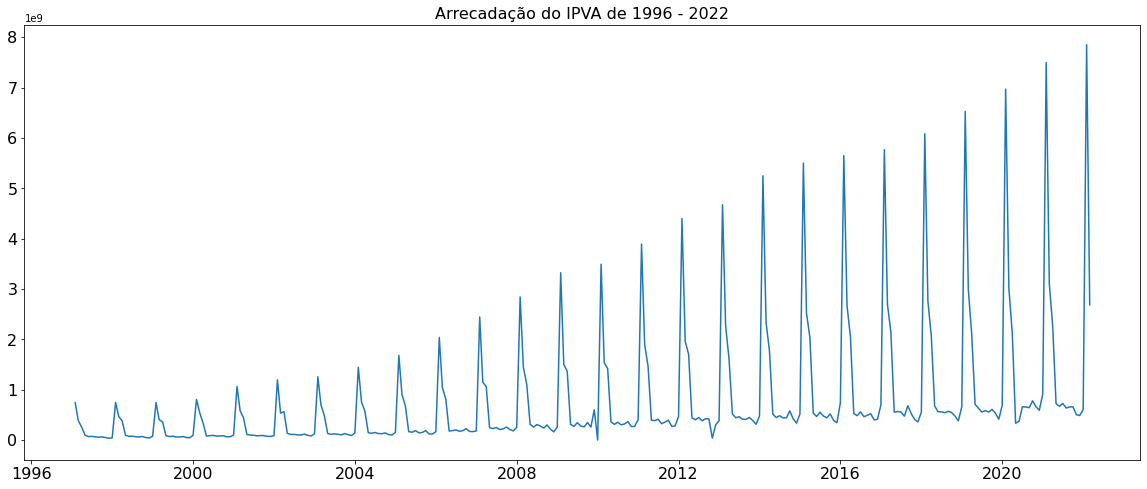

In [6]:
plt.tick_params(axis='x', labelsize=16)
plt.tick_params(axis='y', labelsize=16)
plt.title('Arrecadação do IPVA de 1996 - 2022')
plt.plot(df.IPVA)

___
## Cálculo para a descoberta da relação entre os componentes e extração da Tendência.
Os método utilizados para a descoberta da relação dos componentes foi a <b>Média Móvel Centrada</b> em conjunto com o <b>Desvio Padrão Móvel Centrado</b>.

Para a extração da Tendência foram utilizados dois métodos diferentes:
<br><b>1. Média Móvel Centrada
<br>2. Modelo de Regressão Linear/Polinomial (Sklearn)

### 1. Média Móvel Centrada e Desvio Padrão Móvel

In [7]:
mavg_trend = df.IPVA.rolling(window=12, center=True).mean()
moving_std = df.IPVA.rolling(window=12, center=True).std()

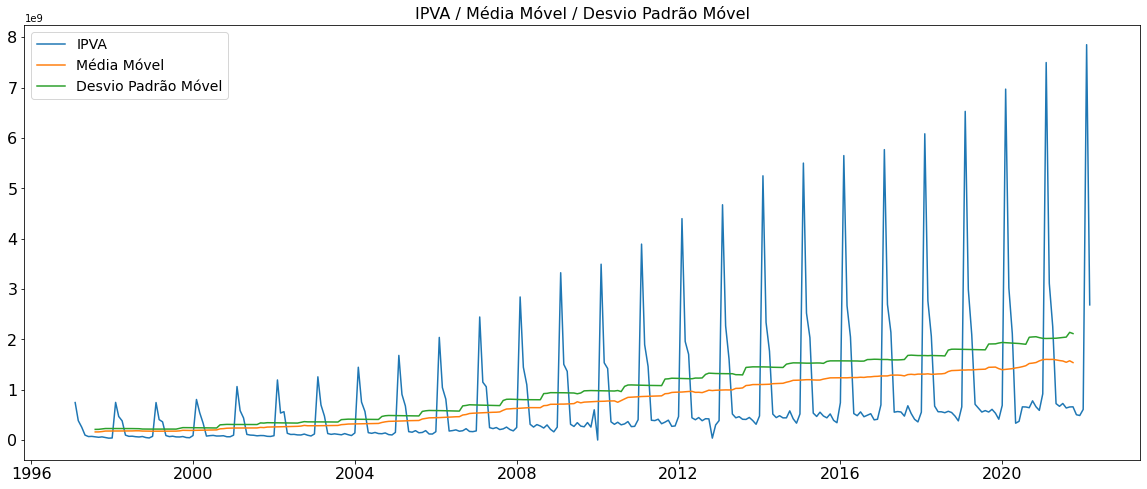

In [8]:
plt.tick_params(axis='x', labelsize=16)
plt.tick_params(axis='y', labelsize=16)
plt.title('IPVA / Média Móvel / Desvio Padrão Móvel')
plt.plot(df.IPVA, label='IPVA')
plt.plot(mavg_trend, label='Média Móvel')
plt.plot(moving_std, label='Desvio Padrão Móvel')
plt.legend()

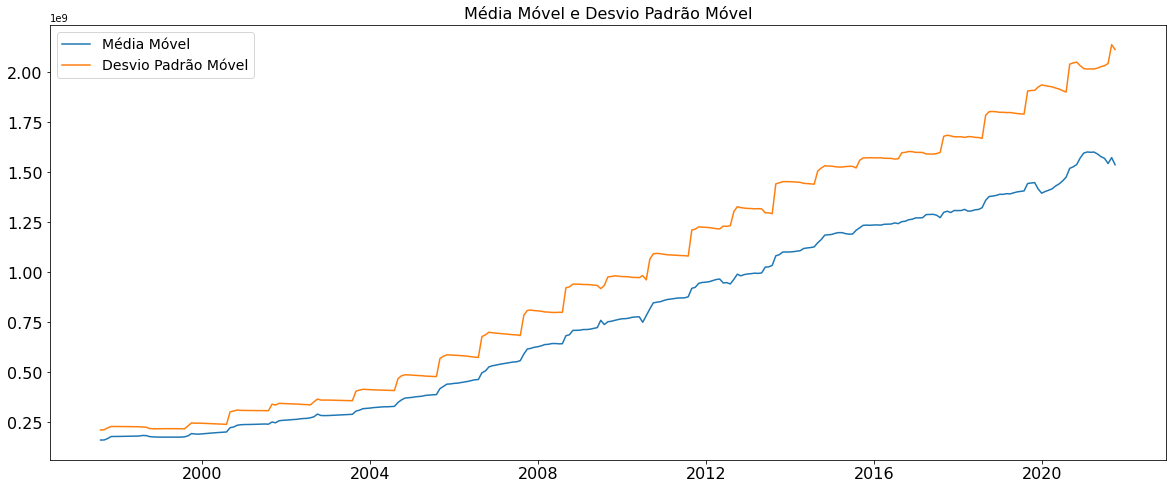

In [9]:
plt.tick_params(axis='x', labelsize=16)
plt.tick_params(axis='y', labelsize=16)
plt.title('Média Móvel e Desvio Padrão Móvel')
plt.plot(mavg_trend, label='Média Móvel')
plt.plot(moving_std, label='Desvio Padrão Móvel')
plt.legend()

#### É possível observar que tanto a Média Móvel, quanto  o Desvio Padrão Móvel possuem uma tendência de crescimento.

Com isso, podemos descartar a relação aditiva entre os componentes e testar a relação multiplicativa.

In [10]:
display(mavg_trend.head(7))
display(mavg_trend.tail(6))

data
1997-01-31             NaN
1997-02-28             NaN
1997-03-31             NaN
1997-04-30             NaN
1997-05-31             NaN
1997-06-30             NaN
1997-07-31    1.609169e+08
Freq: M, Name: IPVA, dtype: float64

data
2021-09-30    1.538174e+09
2021-10-31             NaN
2021-11-30             NaN
2021-12-31             NaN
2022-01-31             NaN
2022-02-28             NaN
Freq: M, Name: IPVA, dtype: float64


### 2. DeterministicProcess em conjunto com o modelo LinearRegression do Sklearn

In [11]:
dp = DeterministicProcess(df.index, order=3)
trend = dp.in_sample()
trend.head()

,trend,trend_squared,trend_cubed
data,,,
1997-01-31,1.0,1.0,1.0
1997-02-28,2.0,4.0,8.0
1997-03-31,3.0,9.0,27.0
1997-04-30,4.0,16.0,64.0
1997-05-31,5.0,25.0,125.0


In [12]:
model = LinearRegression()
model.fit(trend, df.IPVA)
pred_trend = pd.Series(data=model.predict(trend), index=trend.index)

In [13]:
formula = f'f(x) = {model.coef_[0]:.2f}*X + {model.coef_[1]:.2f}*X² + {model.coef_[0]:.2f}*X³ + {model.intercept_:.2f}'
display(formula)

'f(x) = 36777.36*X + 30798.17*X² + 36777.36*X³ + 165321372.25'

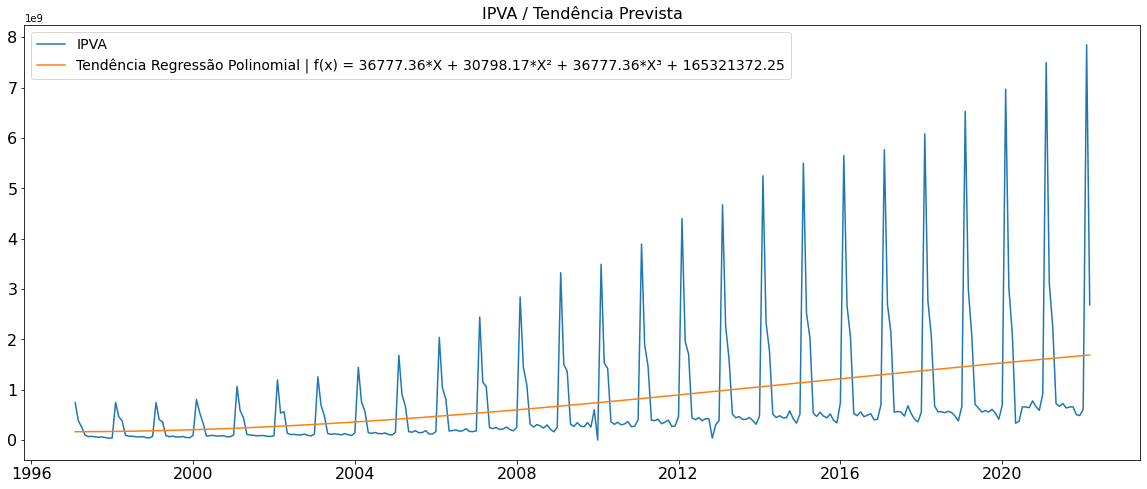

In [14]:
plt.tick_params(axis='x', labelsize=16)
plt.tick_params(axis='y', labelsize=16)
plt.title('IPVA / Tendência Prevista')
plt.plot(df.IPVA, label='IPVA')
plt.plot(pred_trend, label=f'Tendência Regressão Polinomial | {formula}')
plt.legend()

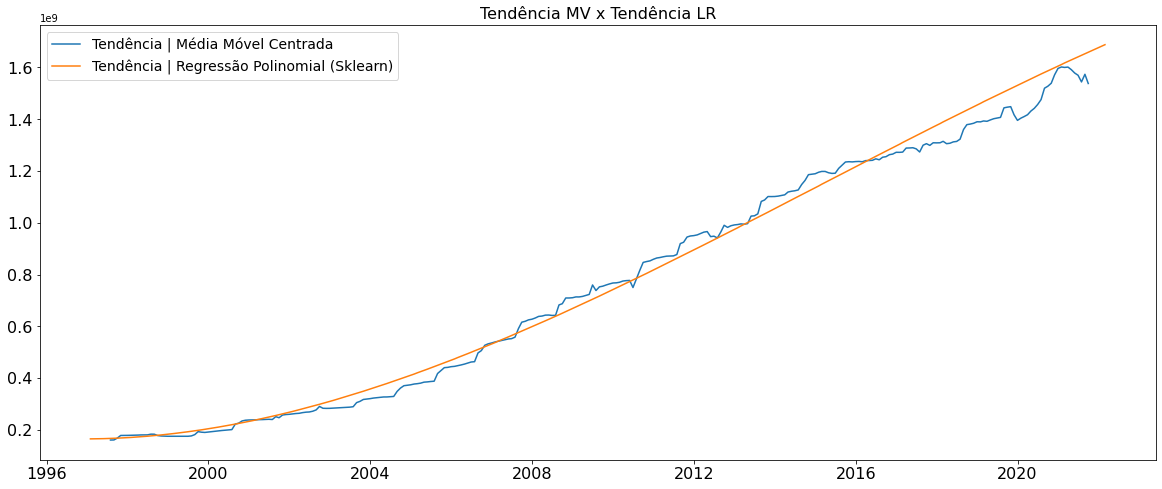

In [15]:
plt.tick_params(axis='x', labelsize=16)
plt.tick_params(axis='y', labelsize=16)
plt.title('Tendência MV x Tendência LR')
plt.plot(mavg_trend, label='Tendência | Média Móvel Centrada')
plt.plot(pred_trend, label='Tendência | Regressão Polinomial (Sklearn)')
plt.legend()

Exclusão da tendência da série temporal:

In [16]:
detrended_lr_ipva = pd.DataFrame(index=df.index, data=df.IPVA / pred_trend, columns=['IPVA'])
detrended_avg_ipva = pd.DataFrame(index=df.index, data=df.IPVA / mavg_trend, columns=['IPVA'])

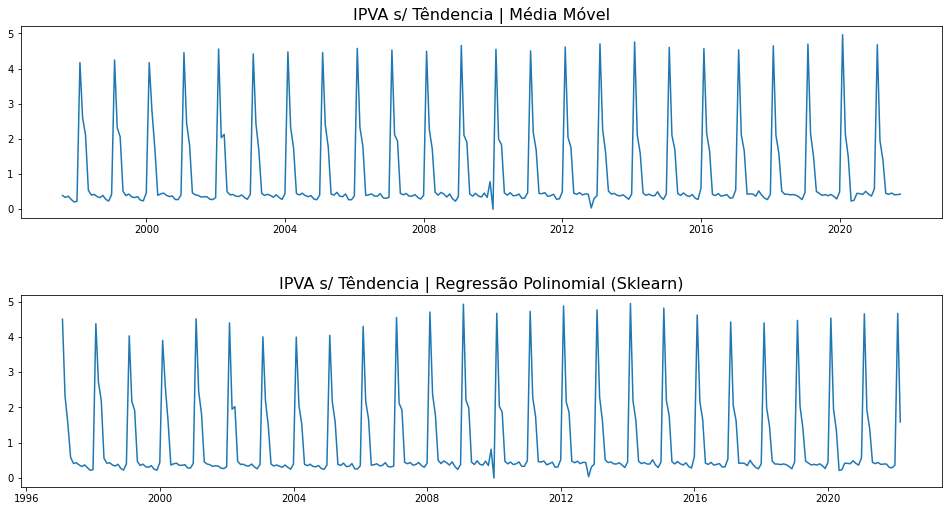

In [17]:
fig, ax = plt.subplots(nrows= 2, figsize=(16,8))
fig.subplots_adjust(left=0.1,
                    bottom=0.1, 
                    right=0.9, 
                    top=0.9, 
                    wspace=0.4, 
                    hspace=0.4)
                    
ax[0].title.set_text('IPVA s/ Têndencia | Média Móvel')
ax[0].plot(detrended_avg_ipva)
ax[1].title.set_text('IPVA s/ Têndencia | Regressão Polinomial (Sklearn)')
ax[1].plot(detrended_lr_ipva)

___
## Calculo da Sazonalidade e aquisição do Erro Aleatório

<b>1. Média dos valores por período sazonal
<br>2. Modelo de Floresta Aleatória (Sklearn)

### 1. Média dos valores por período sazonal


In [18]:
seasonality_m = detrended_lr_ipva.groupby(detrended_lr_ipva.index.month).mean()
seasonality_avg = pd.DataFrame(index=detrended_lr_ipva.index, data=detrended_lr_ipva.index.month)

for month in detrended_lr_ipva.index.month:
    seasonality_avg.loc[seasonality_avg['data'] == month, 'seasonality'] = seasonality_m.loc[seasonality_m.index == month, 'IPVA'].values[0]

seasonality_avg.drop('data', axis=1, inplace=True)

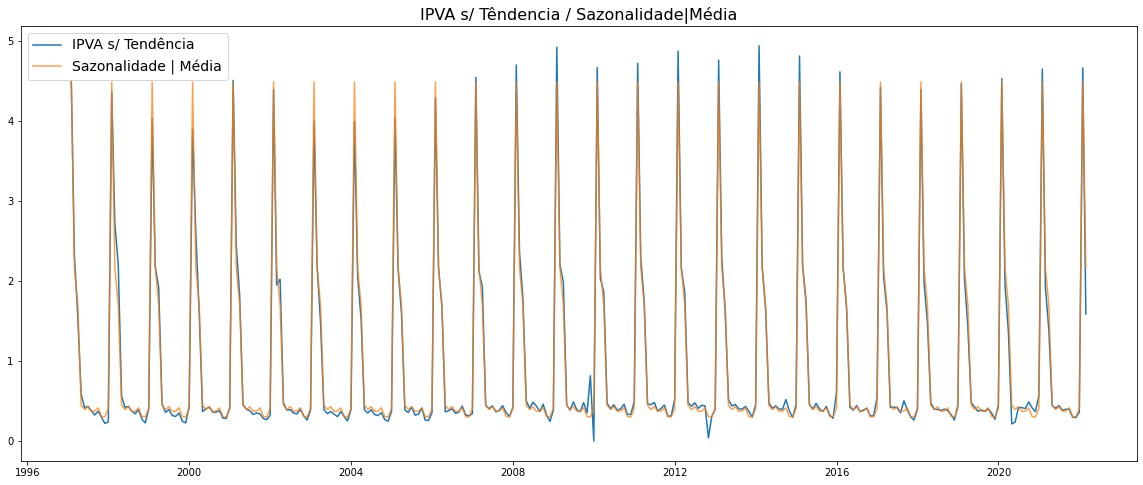

In [19]:
plt.title('IPVA s/ Têndencia / Sazonalidade|Média')
plt.plot(detrended_lr_ipva, label='IPVA s/ Tendência')
plt.plot(seasonality_avg, alpha=0.75, label='Sazonalidade | Média')
plt.legend()

### 2. Modelo de Random Forest do Sklearn

Primeiramente, para treinarmos o modelo com base na sazonalidade, podemos transformar cada mês em uma variável de feature booleana utilizando one-hot-encoding.

In [20]:
X = pd.get_dummies(detrended_lr_ipva.index.month)
y = detrended_lr_ipva.IPVA
display(X)
display(y)

,1,2,3,4,5,6,7,8,9,10,11,12
0,1,0,0,0,0,0,0,0,0,0,0,0
1,0,1,0,0,0,0,0,0,0,0,0,0
2,0,0,1,0,0,0,0,0,0,0,0,0
3,0,0,0,1,0,0,0,0,0,0,0,0
4,0,0,0,0,1,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...
297,0,0,0,0,0,0,0,0,0,1,0,0
298,0,0,0,0,0,0,0,0,0,0,1,0
299,0,0,0,0,0,0,0,0,0,0,0,1
300,1,0,0,0,0,0,0,0,0,0,0,0


data
1997-01-31    4.499032
1997-02-28    2.325113
1997-03-31    1.539701
1997-04-30    0.586868
1997-05-31    0.415321
                ...   
2021-10-31    0.301825
2021-11-30    0.291571
2021-12-31    0.362449
2022-01-31    4.667084
2022-02-28    1.590078
Freq: M, Name: IPVA, Length: 302, dtype: float64

In [21]:
from sklearn.metrics import mean_absolute_error
season_model = RandomForestRegressor(n_estimators=50)

season_model.fit(X, y)
seasonality_rf = pd.DataFrame(index=detrended_lr_ipva.index, data=season_model.predict(X), columns=['IPVA'])

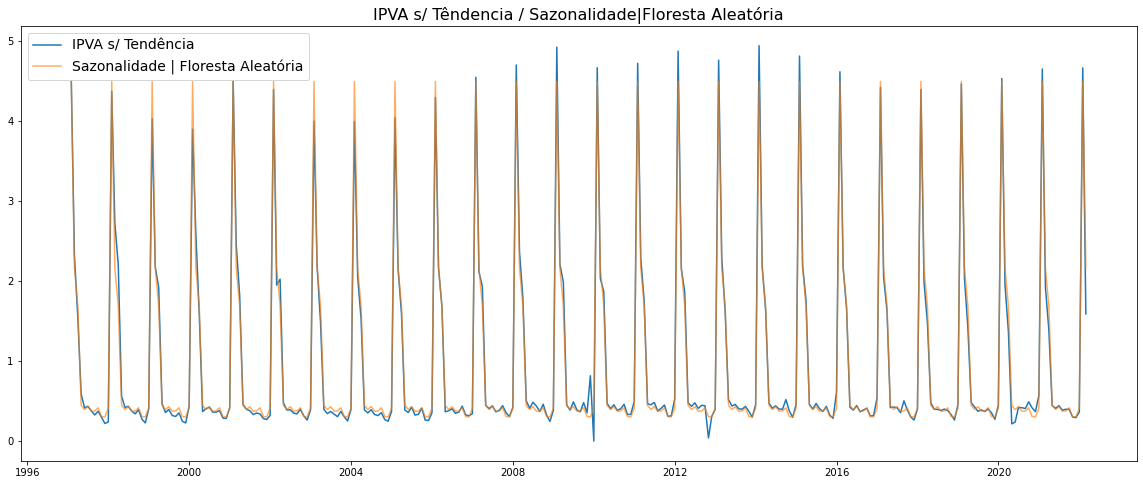

In [22]:
plt.title('IPVA s/ Têndencia / Sazonalidade|Floresta Aleatória')
plt.plot(detrended_lr_ipva, label='IPVA s/ Tendência')
plt.plot(seasonality_rf, alpha=0.65, label='Sazonalidade | Floresta Aleatória')
plt.legend()

#### Comparação do coeficiente de determinação (R²) dos métodos de Média e Floresta Aleatória.

In [23]:
from sklearn.metrics import r2_score
avg_r2 = r2_score(detrended_lr_ipva, seasonality_avg)
rf_r2 = r2_score(detrended_lr_ipva, seasonality_rf)
display(avg_r2)
display(rf_r2)

0.9875419270089004

0.9875285860716351

#### Aquisição do Erro Aleatório:

In [24]:
error = df.IPVA / (pred_trend * seasonality_rf.IPVA)

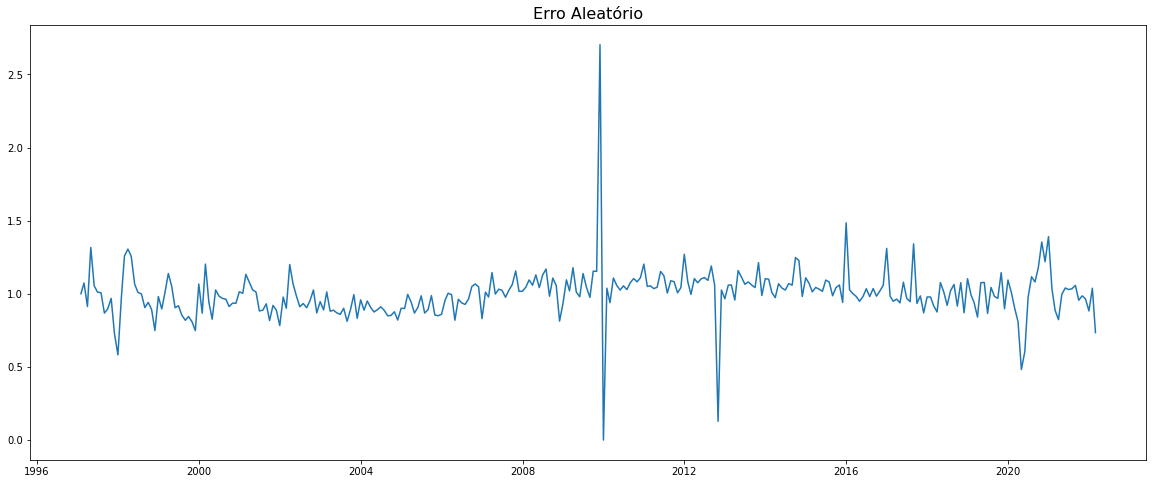

In [25]:
plt.title('Erro Aleatório')
plt.plot(error)

### Plotagem de todos os componentes

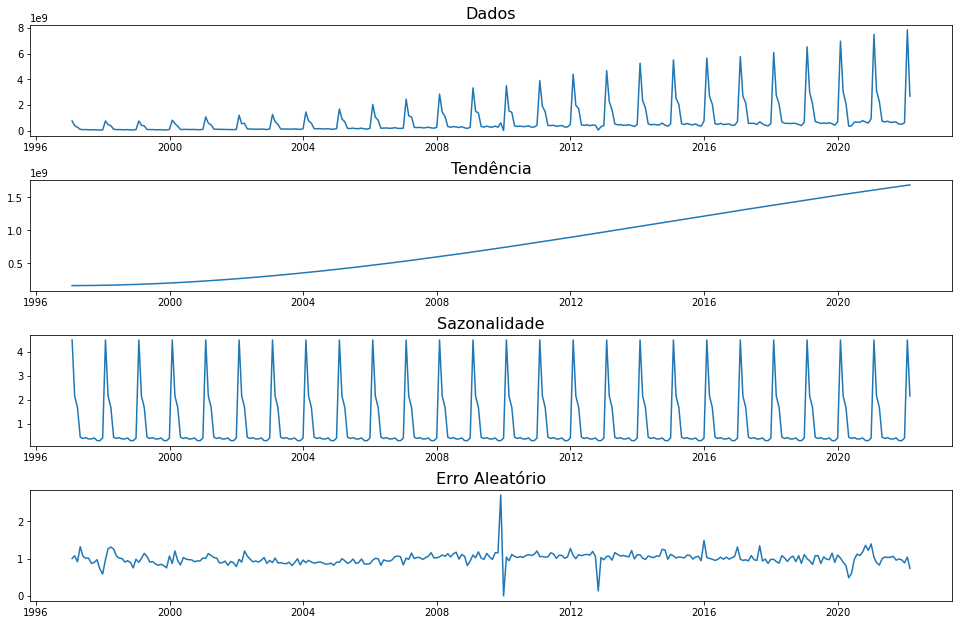

In [26]:
components = {
              'Dados':df,
              'Tendência':pred_trend,
              'Sazonalidade': seasonality_rf,
              'Erro Aleatório':error
              }

fig, ax = plt.subplots(nrows=len(components.keys()), figsize=(16,10))
fig.subplots_adjust(left=0.1,
                    bottom=0.1, 
                    right=0.9, 
                    top=0.9, 
                    wspace=0.4, 
                    hspace=0.4)
                    
for component, i in zip(components.keys(), range(len(components.keys()))):
    ax[i].set_title(component)
    ax[i].plot(components[component])
fig.savefig('components.png')

### Reconstrução da série temporal a partir de seus componentes

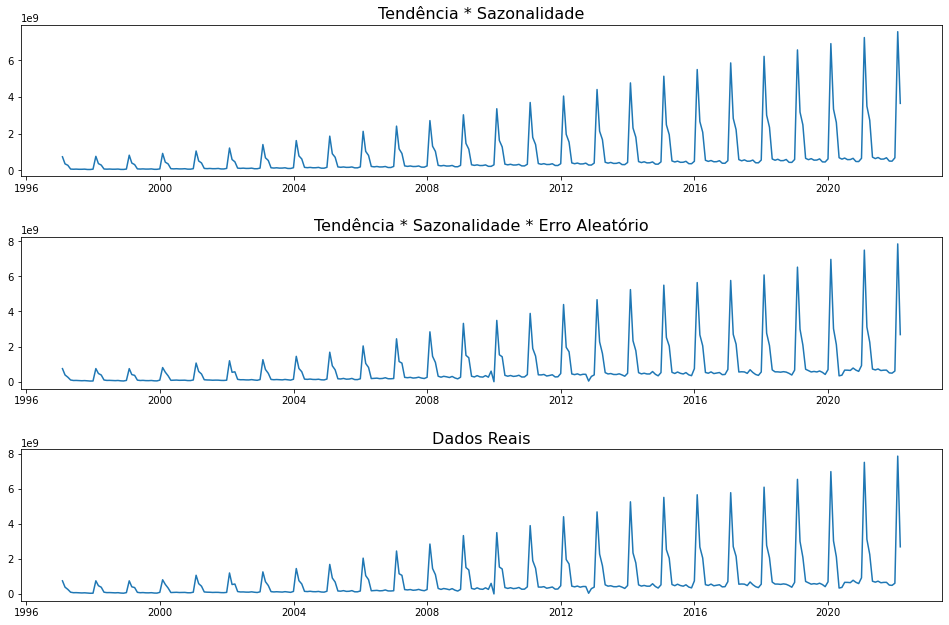

In [27]:
fig, ax = plt.subplots(nrows= 3, figsize=(16,10))
fig.subplots_adjust(left=0.1,
                    bottom=0.1, 
                    right=0.9, 
                    top=0.9, 
                    wspace=0.4, 
                    hspace=0.4)
ax[0].title.set_text('Tendência * Sazonalidade')
ax[0].plot(pred_trend*seasonality_rf.IPVA)
ax[1].title.set_text('Tendência * Sazonalidade * Erro Aleatório')
ax[1].plot(pred_trend*seasonality_rf.IPVA*error)
ax[2].title.set_text('Dados Reais')
ax[2].plot(df.IPVA)